# Shamir Secret Sharing

In this notebook we will study the properties of polynomials to perform secret sharing and defining the properties of sum and multiplication, the protocol we will learn is called Shamir secret sharing and was published by Adi Shamir in 1979, you can read the paper [here](http://users.cms.caltech.edu/~vidick/teaching/101_crypto/Shamir1979.pdf). At the same time will investigate the difference between Shamir secret sharing and additive secret sharing.

## Polynomials

We look at polynomials and their properties. First let's look at a simple polynomial say $$f(x)=3+x+2x^2-x^3$$

and plot it a graph. Also we plot a random sampling of the polynomial points.

<Figure size 432x288 with 0 Axes>

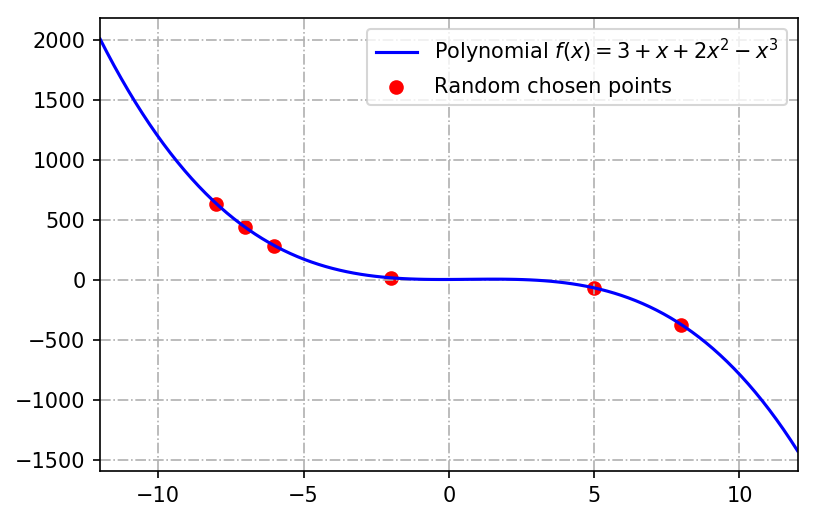

Random points are:
[(-6, 285), (8, -373), (-8, 635), (-2, 17), (-7, 437), (5, -67)]


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from random import randrange, seed

seed(1)

# Defining the polynomial
def poly3(x):
    return 3+1*x+2*x**2-x**3

# Generate 5 random points
points = []
while len(points)<6:
    x = randrange(-10, 10)
    points.append((x, poly3(x)))

# Plotting
plt.clf()
x = np.linspace(-12,12,100)
fig=plt.figure(dpi = 150)
ax = fig.add_subplot(1, 1, 1)

# plot the function
plt.plot(x,poly3(x), 'b', label="Polynomial $f(x)=3+x+2x^2-x^3$")
plt.scatter([a[0] for a in points], [a[1] for a in points], c='r', label="Random chosen points")

plt.legend()
plt.grid(linestyle="-.")
plt.xlim(-12, 12)
plt.show()

print(f"Random points are:\n{points}")

Can we reconstruct the exact full polynomial with few random sampled points? The answer is yes, we need as many as $t$ points, being $t$ larger than $n$ the degree of the polynomial. Imagine we want to fit a line, how many points do we need? just two, a parabola? we need three points and so on. This uniqueness of solution allows to define a sharing scheme over polinomials.

## Shamir

Think of the field (mathematically speaking) of all the polynomials whose coeficients are in the field $Z$ modulo p, for ideally a large prime. We can define a secret as the independent term of the polinomial, this is:
$$f(x)=s+a_1x+a_2x^2+...+a_nx^n$$

where $n$ is the degree and all the coefficients are randomly chosen values in $Z$ modulo p. Let me define a function to randomly saple a polinomial with a secret

In [2]:
from crypt import RandomPrime
from random import randrange

bits = 16
p = RandomPrime(bits, 40)

print(f"Chosen prime number p={p} of {bits} bits")

def RandomPolynomial(s, n, p):
    # s is the secret, n the degree of polynomial and p the prime number for the field
    coef = [s]
    while len(coef)<n+1:
        coef.append(randrange(1, p))
    return coef

secret = 10
degree = 5
coefficients = RandomPolynomial(secret, degree, p)

print(f"A random polynomial drawn from the coefficient field F_p:\n")
for i, coef in enumerate(coefficients):
    if i==0:
        print(f"secret = a{i} = {coef}")
    else:
        print(f"a{i} = {coef}")

Chosen prime number p=61129 of 16 bits
A random polynomial drawn from the coefficient field F_p:

secret = a0 = 10
a1 = 18992
a2 = 60720
a3 = 1409
a4 = 27275
a5 = 54892


Making the shares at this point is easy, we just have to draw as many random points as we want and send them to the parties. Let's make a function to evaluate the polynomial at certain points given their coefficients.

In [3]:
def PolyEvaluate(coef, x):
    # Horner's method to evaluate polynomial
    # coef is a list of the coefficients [a0, a1,..., an]
    n = len(coef)
    coef = coef[::-1]
    r = coef[0]   
    for i in range(1, n): 
        r = r*x + coef[i] 
    return r 


## Using machine learing to guess the polynomial

Before moving on with addition and multiplication in polynomials we will try to guess how much can we reconstruct of a polynomial having some points. To do that we will use ordinary least squares (basically a linear regression) to try to guess the coefficients. Since it is a convex problem we don't need to optimise any learning rate hyperparameter, instead this is just a matrix inversion operation (not detailed here).

In [4]:
bits = 2
p = RandomPrime(bits, 40)

# points to randomly sample, degree of poly and secret

degree = 3
secret = 10

coef = RandomPolynomial(secret, degree, p)
print(f"Generating a random polynomial of degree {degree} and secret {secret} over prime number {p}")
print(f"Coefficients of random polynomial: {coef}")

Generating a random polynomial of degree 3 and secret 10 over prime number 3
Coefficients of random polynomial: [10, 1, 2, 2]


I write a helper function to draw random points and generate the data for the fit. Recall that what we do is simply find a random variable $x$ and get $f(x)$ without adding any noise.

In [5]:
import statsmodels.api as sm

def _generate_data(n_points, degree, coef):
    x = []
    while len(x)<n_points+1:
        i = randrange(-10, 10)
        x.append(i)
    x = np.array(x)

    s = []
    while len(s)<degree:
        s.append(x**(len(s)+1))

    X = np.column_stack(s)
    # Add the independent term
    X = sm.add_constant(X)
    y = np.array([PolyEvaluate(coef, point) for point in x])
    
    return X, y, x


### Number of drawn points smaller than polynomial degree

In [6]:
n_points = 2

X, y, x = _generate_data(n_points, degree, coef)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
print(f"Coefficients of random polynomial: {coef}")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 07 Feb 2020   Prob (F-statistic):                nan
Time:                        17:18:15   Log-Likelihood:                 81.409
No. Observations:                   3   AIC:                            -156.8
Df Residuals:                       0   BIC:                            -159.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9091        inf          0        n

/usr/local/lib/python3.7/site-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  "samples were given." % int(n), ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1698: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
/usr/local/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1620: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


As yu can see the polynomial coefficients are by no means similar to the ones generated randomly, also the standard error calculated is numerically infinite. This intuitively means that we cannot recostruct the polynomial. In fact this is well known in the data science community, the model is too complex (high degree of polynomial) to fit the data (fewer points), this is called underfitting. Let's see a plot of the data and the generated one



<Figure size 432x288 with 0 Axes>

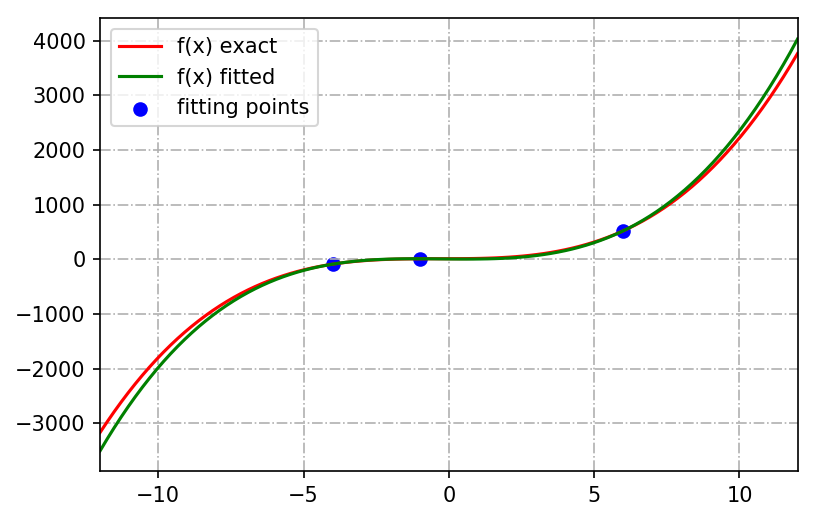

Random points are:
[ 6 -4 -1]
Coefficients of random polynomial: [10, 1, 2, 2]


In [7]:
fitted_coef = results.params

# Plotting
plt.clf()

fig=plt.figure(dpi = 150)
ax = fig.add_subplot(1, 1, 1)

# plot the function
r = np.linspace(-12,12,100)
plt.scatter(x, [PolyEvaluate(coef, a) for a in x], c='b', label="fitting points")
plt.plot(r, [PolyEvaluate(coef, a) for a in r], 'r', label=f"f(x) exact")
plt.plot(r, [PolyEvaluate(fitted_coef, a) for a in r], 'g', label=f"f(x) fitted")

plt.legend()
plt.grid(linestyle="-.")
plt.xlim(-12, 12)
plt.show()

print(f"Random points are:\n{x}")
print(f"Coefficients of random polynomial: {coef}")

It looks as if the two graphs are very similar, in fact they both pass through the points (x, y) selected. The fitted polynomial lacks information and this is why even though he can reconstruct much of the curve it has long tails where no information is provided.

### Number of drawn points larger than polynomial degree`

In [8]:
n_points = 10

X, y, x = _generate_data(n_points, degree, coef)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
print(f"Coefficients of random polynomial: {coef}")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.520e+30
Date:                Fri, 07 Feb 2020   Prob (F-statistic):          3.87e-107
Time:                        17:18:16   Log-Likelihood:                 299.81
No. Observations:                  11   AIC:                            -591.6
Df Residuals:                       7   BIC:                            -590.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.0000   2.18e-13   4.58e+13      0.0

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


Here you can see that now the coefficients are matched perfectly (if you compare with the original data) and the standard error of them is very small. A large $t$ indicates that we have strong evidence that these values are correct (using t-statistics). See that we recovered the secret!. Let's again plot the two lines, the origial polynomial and the fitted one.

<Figure size 432x288 with 0 Axes>

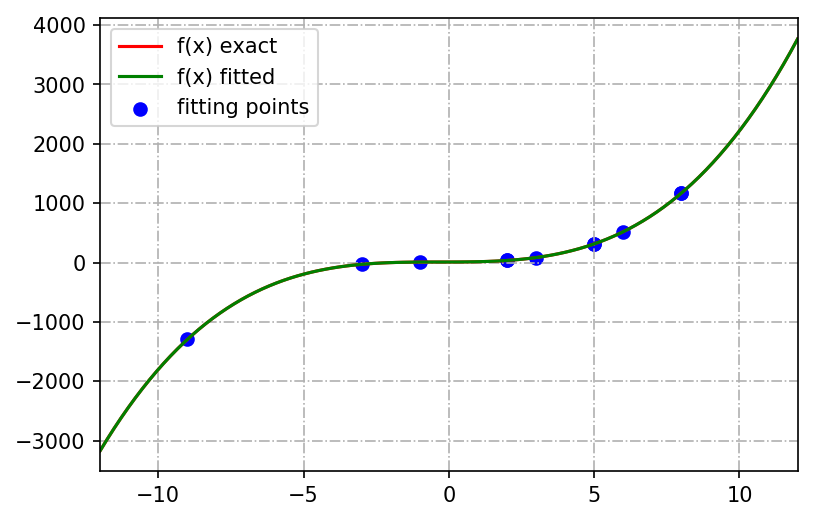

Random points are:
[-1  8  5  6  2  8 -9  5 -3  2  3]
Coefficients of random polynomial: [10, 1, 2, 2]


In [9]:
fitted_coef = results.params

# Plotting
plt.clf()

fig=plt.figure(dpi = 150)
ax = fig.add_subplot(1, 1, 1)

# plot the function
r = np.linspace(-12,12,100)
plt.scatter(x, [PolyEvaluate(coef, a) for a in x], c='b', label="fitting points")
plt.plot(r, [PolyEvaluate(coef, a) for a in r], 'r', label=f"f(x) exact")
plt.plot(r, [PolyEvaluate(fitted_coef, a) for a in r], 'g', label=f"f(x) fitted")

plt.legend()
plt.grid(linestyle="-.")
plt.xlim(-12, 12)
plt.show()

print(f"Random points are:\n{x}")
print(f"Coefficients of random polynomial: {coef}")

This time both lines lie one on top of the other. We have "perfectly" reconstructed the original polynomial by sampling $t$>$n$ points.


## Lagrange polynomial reconstruction

The reconstruction shown above has a strong assumption, this is, we consider that the coefficients of the polynomial are real numbers. This means that if we find that the secret is 10 with a very small standard deviation we are quite sure that the value is close to 10 but it could also be 10.00000001. We are lucky because we work on the field of polynomials with coefficients in $\mathbb{Z}_p$ and so the coefficinets are constrained by the natural numbers.

This kind of polynomials on $\mathbb{Z}_p$ can be reconstructed exactly using [Lagrange interpolation](https://en.wikipedia.org/wiki/Lagrange_polynomial). 